In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

Modified timestamps for file u00001s00001_hw00002.svc:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32




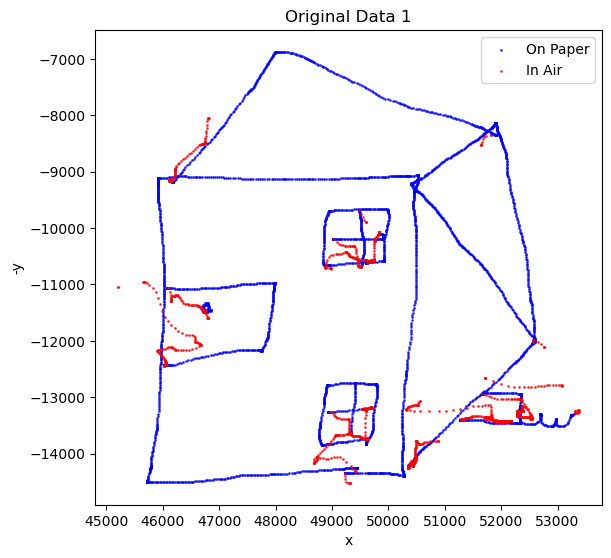

Number of processed files: 1
Average number of data points: 5553


In [2]:
# Cell 2

def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Plot with a 90-degree right rotation (swap x and y)
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(on_paper['x'], -on_paper['y'], c='blue', s=1, alpha=0.7, label='On Paper')  # Swap x and y, negate y
        axs[i].scatter(in_air['x'], -in_air['y'], c='red', s=1, alpha=0.7, label='In Air')  # Swap x and y, negate y
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('x')  # x-axis is 'x'
        axs[i].set_ylabel('-y')  # y-axis is '-y'
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

directory = 'Task2'  # Directory where the .svc files are stored
num_files_to_use = 1
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [3]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 8].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 7

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 7

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)

    # Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [4]:

# Cell 4
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    print(f"Processed DataFrame for: {input_filename}")



Processed DataFrame for: u00001s00001_hw00002.svc


In [5]:
# Cell 5 (modified, no visualization)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for DataFrame {i + 1}:")
        print(df['timestamp'].head())
        print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
# print(f"Average number of data points: {avg_data_points}")


Modified timestamps for DataFrame 1:
0     0
1     7
2    15
3    22
4    30
Name: timestamp, dtype: int32


Number of processed files: 1


In [6]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, **kwargs):  # Added **kwargs to handle extra arguments
        super(VAE, self).__init__(**kwargs)  # Pass kwargs to the parent class
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        # Handle any unexpected keys like 'trainable' by removing them
        config.pop('trainable', None)
        config.pop('dtype', None)  # Also remove 'dtype' if included
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        # Add the VAE-specific arguments
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 512
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        
        # Retain original columns for pressure, azimuth, and altitude
        original_data = data_frames[i % num_input_files]  # Use original unprocessed data
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        # Determine the number of points for this augmented dataset
        # num_points = int(avg_data_points * (1 + np.random.uniform(-length_variability, length_variability)))
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        # Encode and reparameterize
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()
        
        # # Adjust number of points
        # if num_points > augmented_data.shape[0]:
        #     extra_indices = np.random.choice(augmented_data.shape[0], num_points - augmented_data.shape[0])
        #     augmented_data = np.vstack((augmented_data, augmented_data[extra_indices]))
        # elif num_points < augmented_data.shape[0]:
        #     keep_indices = np.random.choice(augmented_data.shape[0], num_points, replace=False)
        #     augmented_data = augmented_data[keep_indices]

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        # Append the pressure, azimuth, and altitude columns from the original data
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 12/12 [00:06<00:00,  1.73batch/s, Generator Loss=0.00897, Reconstruction Loss=0.00897, KL Loss=1.02] 


Epoch 1: Generator Loss = 0.010184, Reconstruction Loss = 0.010183, KL Divergence Loss = 0.953977
NRMSE = 0.301781


Epoch 2/100: 100%|██████████| 12/12 [00:01<00:00, 11.43batch/s, Generator Loss=0.00873, Reconstruction Loss=0.00873, KL Loss=1.08]


Epoch 2: Generator Loss = 0.009061, Reconstruction Loss = 0.009060, KL Divergence Loss = 1.048683
NRMSE = 0.305464


Epoch 3/100: 100%|██████████| 12/12 [00:01<00:00, 11.15batch/s, Generator Loss=0.00822, Reconstruction Loss=0.00822, KL Loss=1.19]


Epoch 3: Generator Loss = 0.008403, Reconstruction Loss = 0.008402, KL Divergence Loss = 1.135705
NRMSE = 0.307900


Epoch 4/100: 100%|██████████| 12/12 [00:00<00:00, 13.87batch/s, Generator Loss=0.00608, Reconstruction Loss=0.00608, KL Loss=1.24]


Epoch 4: Generator Loss = 0.007581, Reconstruction Loss = 0.007580, KL Divergence Loss = 1.220990
NRMSE = 0.307854


Epoch 5/100: 100%|██████████| 12/12 [00:01<00:00,  8.33batch/s, Generator Loss=0.00742, Reconstruction Loss=0.00742, KL Loss=1.33]


Epoch 5: Generator Loss = 0.007100, Reconstruction Loss = 0.007098, KL Divergence Loss = 1.306202
NRMSE = 0.310893


Epoch 6/100: 100%|██████████| 12/12 [00:01<00:00, 11.94batch/s, Generator Loss=0.00754, Reconstruction Loss=0.00754, KL Loss=1.4] 


Epoch 6: Generator Loss = 0.006605, Reconstruction Loss = 0.006604, KL Divergence Loss = 1.387390
NRMSE = 0.310634


Epoch 7/100: 100%|██████████| 12/12 [00:00<00:00, 13.72batch/s, Generator Loss=0.00634, Reconstruction Loss=0.00633, KL Loss=1.5] 


Epoch 7: Generator Loss = 0.006039, Reconstruction Loss = 0.006037, KL Divergence Loss = 1.473051
NRMSE = 0.313635


Epoch 8/100: 100%|██████████| 12/12 [00:00<00:00, 13.21batch/s, Generator Loss=0.00553, Reconstruction Loss=0.00553, KL Loss=1.58]


Epoch 8: Generator Loss = 0.005597, Reconstruction Loss = 0.005595, KL Divergence Loss = 1.557639
NRMSE = 0.315279


Epoch 9/100: 100%|██████████| 12/12 [00:01<00:00,  8.96batch/s, Generator Loss=0.00493, Reconstruction Loss=0.00492, KL Loss=1.67]


Epoch 9: Generator Loss = 0.004894, Reconstruction Loss = 0.004893, KL Divergence Loss = 1.648311
NRMSE = 0.316595


Epoch 10/100: 100%|██████████| 12/12 [00:00<00:00, 12.11batch/s, Generator Loss=0.00421, Reconstruction Loss=0.00421, KL Loss=1.75]


Epoch 10: Generator Loss = 0.004333, Reconstruction Loss = 0.004331, KL Divergence Loss = 1.727261
NRMSE = 0.316466


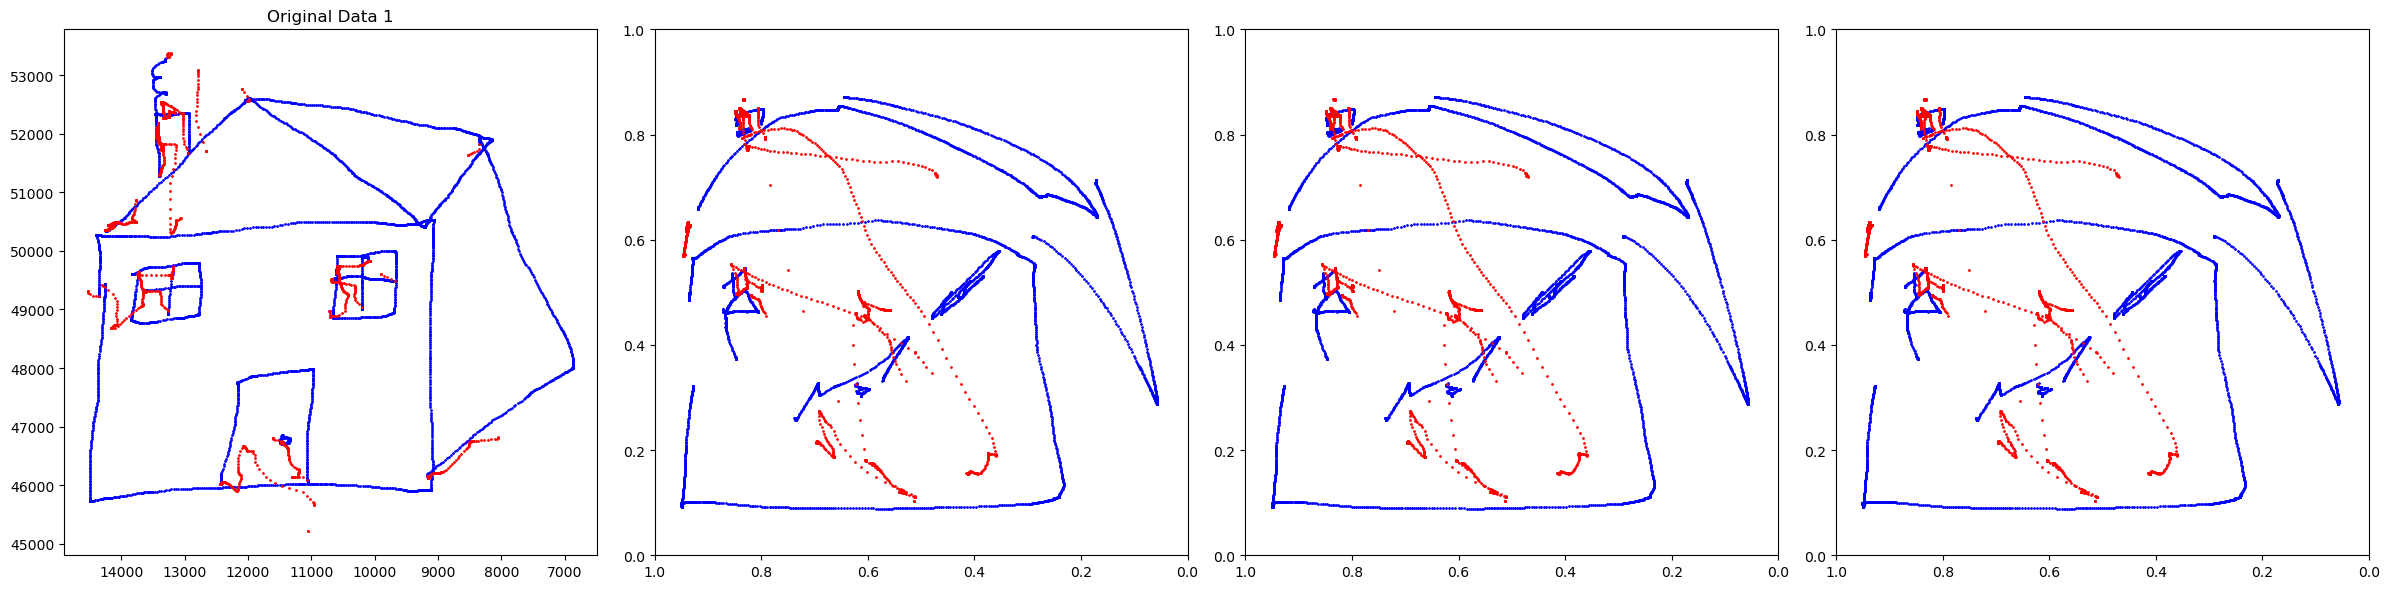

VAE model saved for epoch 10 at vae_models\epoch_10_model.h5.


Epoch 11/100: 100%|██████████| 12/12 [00:01<00:00,  9.81batch/s, Generator Loss=0.00368, Reconstruction Loss=0.00368, KL Loss=1.86]


Epoch 11: Generator Loss = 0.003956, Reconstruction Loss = 0.003954, KL Divergence Loss = 1.804791
NRMSE = 0.317419


Epoch 12/100: 100%|██████████| 12/12 [00:01<00:00, 11.39batch/s, Generator Loss=0.00376, Reconstruction Loss=0.00375, KL Loss=1.92]


Epoch 12: Generator Loss = 0.003733, Reconstruction Loss = 0.003731, KL Divergence Loss = 1.876719
NRMSE = 0.318755


Epoch 13/100: 100%|██████████| 12/12 [00:01<00:00,  9.34batch/s, Generator Loss=0.003, Reconstruction Loss=0.003, KL Loss=1.94]    


Epoch 13: Generator Loss = 0.003445, Reconstruction Loss = 0.003443, KL Divergence Loss = 1.944305
NRMSE = 0.320046


Epoch 14/100: 100%|██████████| 12/12 [00:01<00:00, 10.36batch/s, Generator Loss=0.00336, Reconstruction Loss=0.00335, KL Loss=2.04]


Epoch 14: Generator Loss = 0.003062, Reconstruction Loss = 0.003060, KL Divergence Loss = 2.003318
NRMSE = 0.320398


Epoch 15/100: 100%|██████████| 12/12 [00:01<00:00, 11.93batch/s, Generator Loss=0.00287, Reconstruction Loss=0.00287, KL Loss=2.08]


Epoch 15: Generator Loss = 0.002877, Reconstruction Loss = 0.002874, KL Divergence Loss = 2.064995
NRMSE = 0.319201


Epoch 16/100: 100%|██████████| 12/12 [00:01<00:00,  9.11batch/s, Generator Loss=0.00287, Reconstruction Loss=0.00287, KL Loss=2.12]


Epoch 16: Generator Loss = 0.002638, Reconstruction Loss = 0.002636, KL Divergence Loss = 2.114594
NRMSE = 0.321009


Epoch 17/100: 100%|██████████| 12/12 [00:01<00:00,  8.58batch/s, Generator Loss=0.00267, Reconstruction Loss=0.00266, KL Loss=2.16]


Epoch 17: Generator Loss = 0.002466, Reconstruction Loss = 0.002464, KL Divergence Loss = 2.171537
NRMSE = 0.321391


Epoch 18/100: 100%|██████████| 12/12 [00:01<00:00, 10.87batch/s, Generator Loss=0.00198, Reconstruction Loss=0.00198, KL Loss=2.27]


Epoch 18: Generator Loss = 0.002382, Reconstruction Loss = 0.002380, KL Divergence Loss = 2.227897
NRMSE = 0.320555


Epoch 19/100: 100%|██████████| 12/12 [00:00<00:00, 12.49batch/s, Generator Loss=0.00243, Reconstruction Loss=0.00243, KL Loss=2.35]


Epoch 19: Generator Loss = 0.002357, Reconstruction Loss = 0.002355, KL Divergence Loss = 2.282508
NRMSE = 0.321276


Epoch 20/100: 100%|██████████| 12/12 [00:00<00:00, 12.79batch/s, Generator Loss=0.00193, Reconstruction Loss=0.00192, KL Loss=2.38]


Epoch 20: Generator Loss = 0.002265, Reconstruction Loss = 0.002262, KL Divergence Loss = 2.322322
NRMSE = 0.321824


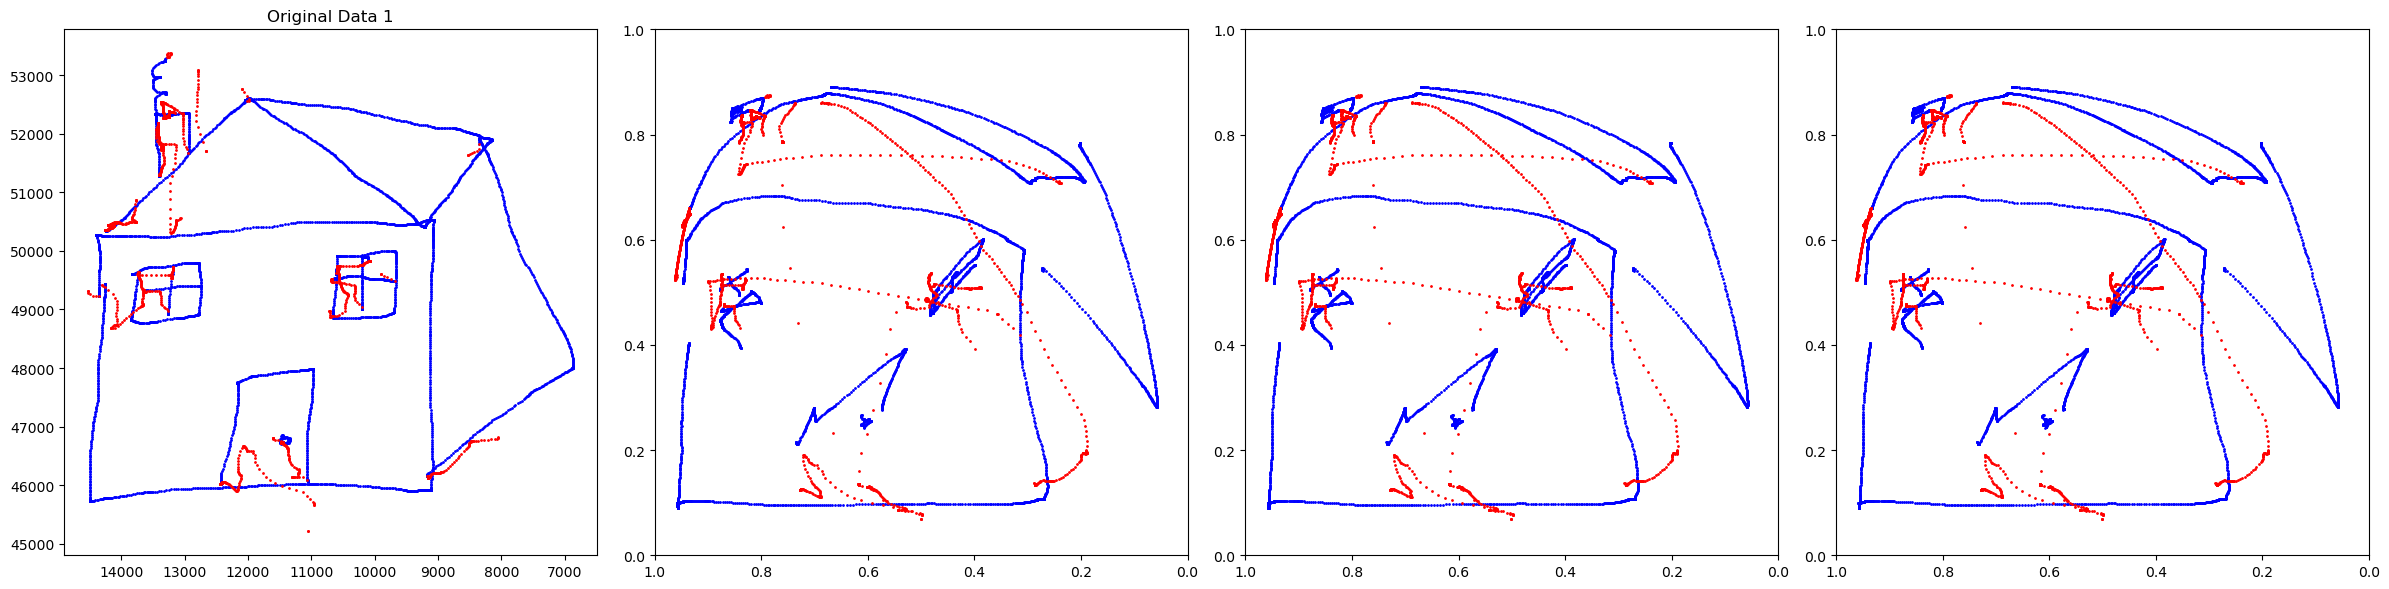

VAE model saved for epoch 20 at vae_models\epoch_20_model.h5.


Epoch 21/100: 100%|██████████| 12/12 [00:02<00:00,  5.49batch/s, Generator Loss=0.00218, Reconstruction Loss=0.00218, KL Loss=2.29]


Epoch 21: Generator Loss = 0.002102, Reconstruction Loss = 0.002100, KL Divergence Loss = 2.360631
NRMSE = 0.321409


Epoch 22/100: 100%|██████████| 12/12 [00:02<00:00,  4.22batch/s, Generator Loss=0.00181, Reconstruction Loss=0.00181, KL Loss=2.49]


Epoch 22: Generator Loss = 0.001999, Reconstruction Loss = 0.001996, KL Divergence Loss = 2.410204
NRMSE = 0.321759


Epoch 23/100: 100%|██████████| 12/12 [00:03<00:00,  3.81batch/s, Generator Loss=0.00186, Reconstruction Loss=0.00186, KL Loss=2.43]


Epoch 23: Generator Loss = 0.001995, Reconstruction Loss = 0.001992, KL Divergence Loss = 2.447448
NRMSE = 0.322366


Epoch 24/100: 100%|██████████| 12/12 [00:03<00:00,  3.51batch/s, Generator Loss=0.00169, Reconstruction Loss=0.00169, KL Loss=2.49]


Epoch 24: Generator Loss = 0.001901, Reconstruction Loss = 0.001899, KL Divergence Loss = 2.487023
NRMSE = 0.322233


Epoch 25/100: 100%|██████████| 12/12 [00:02<00:00,  5.59batch/s, Generator Loss=0.00165, Reconstruction Loss=0.00165, KL Loss=2.58]


Epoch 25: Generator Loss = 0.001880, Reconstruction Loss = 0.001878, KL Divergence Loss = 2.522908
NRMSE = 0.322365


Epoch 26/100: 100%|██████████| 12/12 [00:01<00:00,  7.28batch/s, Generator Loss=0.00215, Reconstruction Loss=0.00215, KL Loss=2.58]


Epoch 26: Generator Loss = 0.001786, Reconstruction Loss = 0.001784, KL Divergence Loss = 2.556683
NRMSE = 0.322339


Epoch 27/100: 100%|██████████| 12/12 [00:01<00:00,  8.19batch/s, Generator Loss=0.0018, Reconstruction Loss=0.0018, KL Loss=2.56]  


Epoch 27: Generator Loss = 0.001766, Reconstruction Loss = 0.001764, KL Divergence Loss = 2.592816
NRMSE = 0.322546


Epoch 28/100: 100%|██████████| 12/12 [00:01<00:00, 10.36batch/s, Generator Loss=0.00165, Reconstruction Loss=0.00165, KL Loss=2.47]


Epoch 28: Generator Loss = 0.001725, Reconstruction Loss = 0.001723, KL Divergence Loss = 2.620636
NRMSE = 0.323341


Epoch 29/100: 100%|██████████| 12/12 [00:00<00:00, 12.95batch/s, Generator Loss=0.00191, Reconstruction Loss=0.00191, KL Loss=2.63]


Epoch 29: Generator Loss = 0.001703, Reconstruction Loss = 0.001700, KL Divergence Loss = 2.656856
NRMSE = 0.323920


Epoch 30/100: 100%|██████████| 12/12 [00:00<00:00, 13.15batch/s, Generator Loss=0.0017, Reconstruction Loss=0.00169, KL Loss=2.66] 


Epoch 30: Generator Loss = 0.001662, Reconstruction Loss = 0.001659, KL Divergence Loss = 2.683196
NRMSE = 0.323073


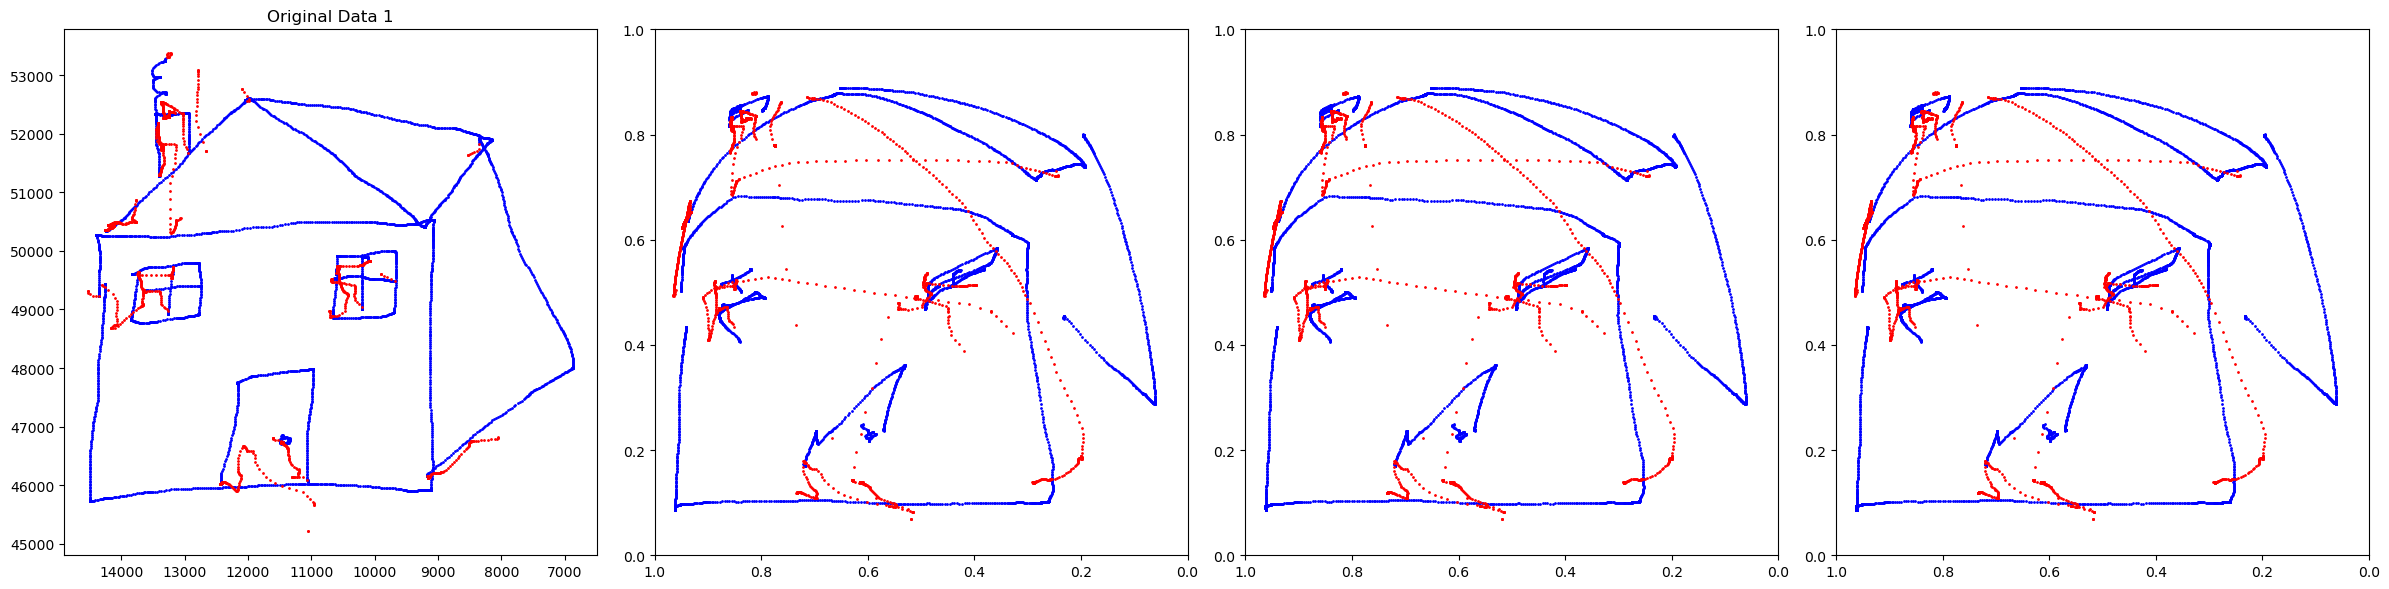

VAE model saved for epoch 30 at vae_models\epoch_30_model.h5.


Epoch 31/100: 100%|██████████| 12/12 [00:00<00:00, 12.10batch/s, Generator Loss=0.00169, Reconstruction Loss=0.00169, KL Loss=2.74]


Epoch 31: Generator Loss = 0.001553, Reconstruction Loss = 0.001551, KL Divergence Loss = 2.712635
NRMSE = 0.324918


Epoch 32/100: 100%|██████████| 12/12 [00:01<00:00,  7.60batch/s, Generator Loss=0.00147, Reconstruction Loss=0.00147, KL Loss=2.82]


Epoch 32: Generator Loss = 0.001512, Reconstruction Loss = 0.001510, KL Divergence Loss = 2.747065
NRMSE = 0.322751


Epoch 33/100: 100%|██████████| 12/12 [00:01<00:00,  8.75batch/s, Generator Loss=0.00103, Reconstruction Loss=0.00103, KL Loss=2.83]


Epoch 33: Generator Loss = 0.001405, Reconstruction Loss = 0.001403, KL Divergence Loss = 2.779930
NRMSE = 0.323600


Epoch 34/100: 100%|██████████| 12/12 [00:01<00:00,  9.94batch/s, Generator Loss=0.0016, Reconstruction Loss=0.0016, KL Loss=2.79]  


Epoch 34: Generator Loss = 0.001459, Reconstruction Loss = 0.001456, KL Divergence Loss = 2.814483
NRMSE = 0.323858


Epoch 35/100: 100%|██████████| 12/12 [00:00<00:00, 12.57batch/s, Generator Loss=0.00122, Reconstruction Loss=0.00122, KL Loss=2.85]


Epoch 35: Generator Loss = 0.001446, Reconstruction Loss = 0.001443, KL Divergence Loss = 2.840864
NRMSE = 0.325030


Epoch 36/100: 100%|██████████| 12/12 [00:01<00:00,  9.17batch/s, Generator Loss=0.00133, Reconstruction Loss=0.00133, KL Loss=2.87]


Epoch 36: Generator Loss = 0.001436, Reconstruction Loss = 0.001434, KL Divergence Loss = 2.866812
NRMSE = 0.324301


Epoch 37/100: 100%|██████████| 12/12 [00:00<00:00, 13.92batch/s, Generator Loss=0.00139, Reconstruction Loss=0.00139, KL Loss=2.93]


Epoch 37: Generator Loss = 0.001317, Reconstruction Loss = 0.001314, KL Divergence Loss = 2.895377
NRMSE = 0.325156


Epoch 38/100: 100%|██████████| 12/12 [00:00<00:00, 12.99batch/s, Generator Loss=0.00112, Reconstruction Loss=0.00111, KL Loss=2.9] 


Epoch 38: Generator Loss = 0.001306, Reconstruction Loss = 0.001303, KL Divergence Loss = 2.925169
NRMSE = 0.324608


Epoch 39/100: 100%|██████████| 12/12 [00:00<00:00, 14.38batch/s, Generator Loss=0.00124, Reconstruction Loss=0.00123, KL Loss=3.01]


Epoch 39: Generator Loss = 0.001220, Reconstruction Loss = 0.001217, KL Divergence Loss = 2.956068
NRMSE = 0.324988


Epoch 40/100: 100%|██████████| 12/12 [00:00<00:00, 13.36batch/s, Generator Loss=0.00164, Reconstruction Loss=0.00164, KL Loss=3]   


Epoch 40: Generator Loss = 0.001361, Reconstruction Loss = 0.001358, KL Divergence Loss = 2.984621
NRMSE = 0.326899


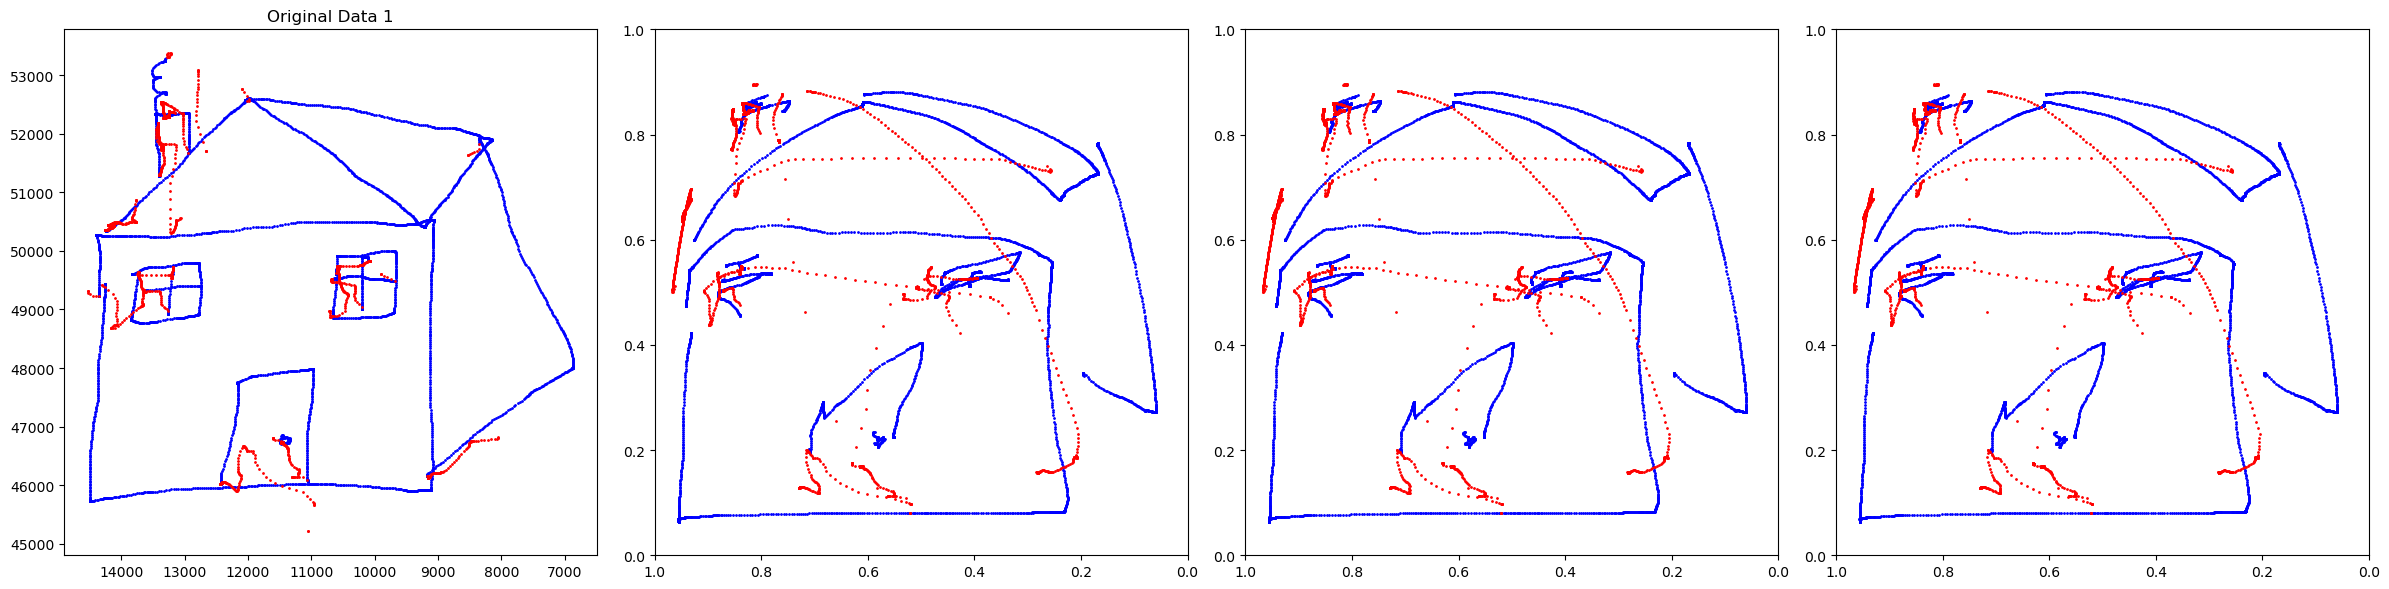

VAE model saved for epoch 40 at vae_models\epoch_40_model.h5.


Epoch 41/100: 100%|██████████| 12/12 [00:01<00:00, 10.50batch/s, Generator Loss=0.00107, Reconstruction Loss=0.00107, KL Loss=3.12]


Epoch 41: Generator Loss = 0.001309, Reconstruction Loss = 0.001306, KL Divergence Loss = 3.003532
NRMSE = 0.326204


Epoch 42/100: 100%|██████████| 12/12 [00:01<00:00, 10.14batch/s, Generator Loss=0.00105, Reconstruction Loss=0.00104, KL Loss=3]    


Epoch 42: Generator Loss = 0.001162, Reconstruction Loss = 0.001159, KL Divergence Loss = 3.015686
NRMSE = 0.326652


Epoch 43/100: 100%|██████████| 12/12 [00:01<00:00,  6.57batch/s, Generator Loss=0.00118, Reconstruction Loss=0.00118, KL Loss=3.09] 


Epoch 43: Generator Loss = 0.001144, Reconstruction Loss = 0.001141, KL Divergence Loss = 3.042133
NRMSE = 0.326540


Epoch 44/100: 100%|██████████| 12/12 [00:01<00:00, 11.34batch/s, Generator Loss=0.00118, Reconstruction Loss=0.00117, KL Loss=3.04]  


Epoch 44: Generator Loss = 0.001118, Reconstruction Loss = 0.001115, KL Divergence Loss = 3.075722
NRMSE = 0.327138


Epoch 45/100: 100%|██████████| 12/12 [00:00<00:00, 14.33batch/s, Generator Loss=0.00135, Reconstruction Loss=0.00135, KL Loss=3.12] 


Epoch 45: Generator Loss = 0.001067, Reconstruction Loss = 0.001064, KL Divergence Loss = 3.107133
NRMSE = 0.326191


Epoch 46/100: 100%|██████████| 12/12 [00:01<00:00,  7.37batch/s, Generator Loss=0.00108, Reconstruction Loss=0.00107, KL Loss=3.1]  


Epoch 46: Generator Loss = 0.001060, Reconstruction Loss = 0.001057, KL Divergence Loss = 3.135168
NRMSE = 0.326581


Epoch 47/100: 100%|██████████| 12/12 [00:01<00:00, 10.01batch/s, Generator Loss=0.000969, Reconstruction Loss=0.000966, KL Loss=3.2]


Epoch 47: Generator Loss = 0.001026, Reconstruction Loss = 0.001022, KL Divergence Loss = 3.159998
NRMSE = 0.327199


Epoch 48/100: 100%|██████████| 12/12 [00:01<00:00,  9.46batch/s, Generator Loss=0.00108, Reconstruction Loss=0.00108, KL Loss=3.13]  


Epoch 48: Generator Loss = 0.000999, Reconstruction Loss = 0.000996, KL Divergence Loss = 3.180231
NRMSE = 0.327550


Epoch 49/100: 100%|██████████| 12/12 [00:01<00:00,  9.68batch/s, Generator Loss=0.000992, Reconstruction Loss=0.000988, KL Loss=3.28]


Epoch 49: Generator Loss = 0.000994, Reconstruction Loss = 0.000991, KL Divergence Loss = 3.206510
NRMSE = 0.326705


Epoch 50/100: 100%|██████████| 12/12 [00:01<00:00, 11.65batch/s, Generator Loss=0.000868, Reconstruction Loss=0.000865, KL Loss=3.22]


Epoch 50: Generator Loss = 0.000964, Reconstruction Loss = 0.000961, KL Divergence Loss = 3.224782
NRMSE = 0.327686


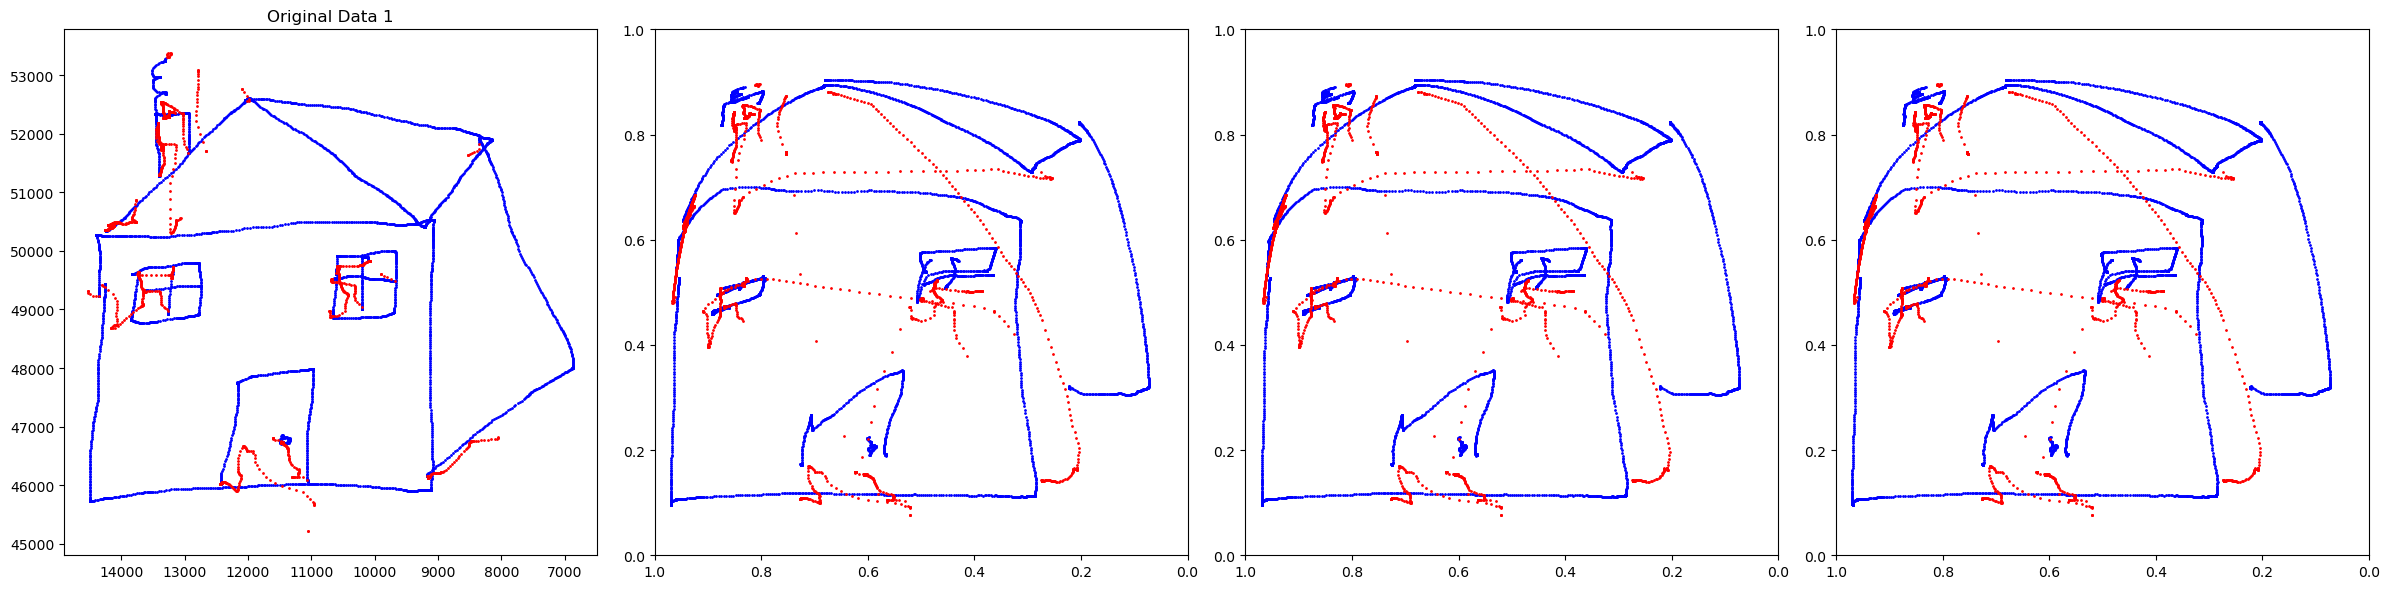

VAE model saved for epoch 50 at vae_models\epoch_50_model.h5.


Epoch 51/100: 100%|██████████| 12/12 [00:01<00:00,  9.96batch/s, Generator Loss=0.000873, Reconstruction Loss=0.00087, KL Loss=3.23] 


Epoch 51: Generator Loss = 0.000972, Reconstruction Loss = 0.000968, KL Divergence Loss = 3.242981
NRMSE = 0.327095


Epoch 52/100: 100%|██████████| 12/12 [00:01<00:00, 10.42batch/s, Generator Loss=0.000918, Reconstruction Loss=0.000915, KL Loss=3.21]


Epoch 52: Generator Loss = 0.000871, Reconstruction Loss = 0.000868, KL Divergence Loss = 3.270441
NRMSE = 0.328500


Epoch 53/100: 100%|██████████| 12/12 [00:01<00:00,  8.20batch/s, Generator Loss=0.000718, Reconstruction Loss=0.000715, KL Loss=3.29]


Epoch 53: Generator Loss = 0.000950, Reconstruction Loss = 0.000947, KL Divergence Loss = 3.284922
NRMSE = 0.326730


Epoch 54/100: 100%|██████████| 12/12 [00:03<00:00,  3.69batch/s, Generator Loss=0.000809, Reconstruction Loss=0.000806, KL Loss=3.3] 


Epoch 54: Generator Loss = 0.000821, Reconstruction Loss = 0.000818, KL Divergence Loss = 3.303601
NRMSE = 0.328379


Epoch 55/100: 100%|██████████| 12/12 [00:01<00:00, 11.11batch/s, Generator Loss=0.000836, Reconstruction Loss=0.000832, KL Loss=3.36]


Epoch 55: Generator Loss = 0.000781, Reconstruction Loss = 0.000778, KL Divergence Loss = 3.325094
NRMSE = 0.327535


Epoch 56/100: 100%|██████████| 12/12 [00:01<00:00, 11.88batch/s, Generator Loss=0.000748, Reconstruction Loss=0.000745, KL Loss=3.4] 


Epoch 56: Generator Loss = 0.000762, Reconstruction Loss = 0.000758, KL Divergence Loss = 3.346337
NRMSE = 0.327761


Epoch 57/100: 100%|██████████| 12/12 [00:00<00:00, 14.39batch/s, Generator Loss=0.000674, Reconstruction Loss=0.000671, KL Loss=3.35]


Epoch 57: Generator Loss = 0.000793, Reconstruction Loss = 0.000790, KL Divergence Loss = 3.364758
NRMSE = 0.327338


Epoch 58/100: 100%|██████████| 12/12 [00:00<00:00, 17.25batch/s, Generator Loss=0.000709, Reconstruction Loss=0.000705, KL Loss=3.38]


Epoch 58: Generator Loss = 0.000814, Reconstruction Loss = 0.000811, KL Divergence Loss = 3.382025
NRMSE = 0.328300


Epoch 59/100: 100%|██████████| 12/12 [00:00<00:00, 18.37batch/s, Generator Loss=0.0008, Reconstruction Loss=0.000797, KL Loss=3.43]  


Epoch 59: Generator Loss = 0.000847, Reconstruction Loss = 0.000844, KL Divergence Loss = 3.394198
NRMSE = 0.328735


Epoch 60/100: 100%|██████████| 12/12 [00:00<00:00, 15.29batch/s, Generator Loss=0.000642, Reconstruction Loss=0.000639, KL Loss=3.37]


Epoch 60: Generator Loss = 0.000772, Reconstruction Loss = 0.000768, KL Divergence Loss = 3.401920
NRMSE = 0.328407


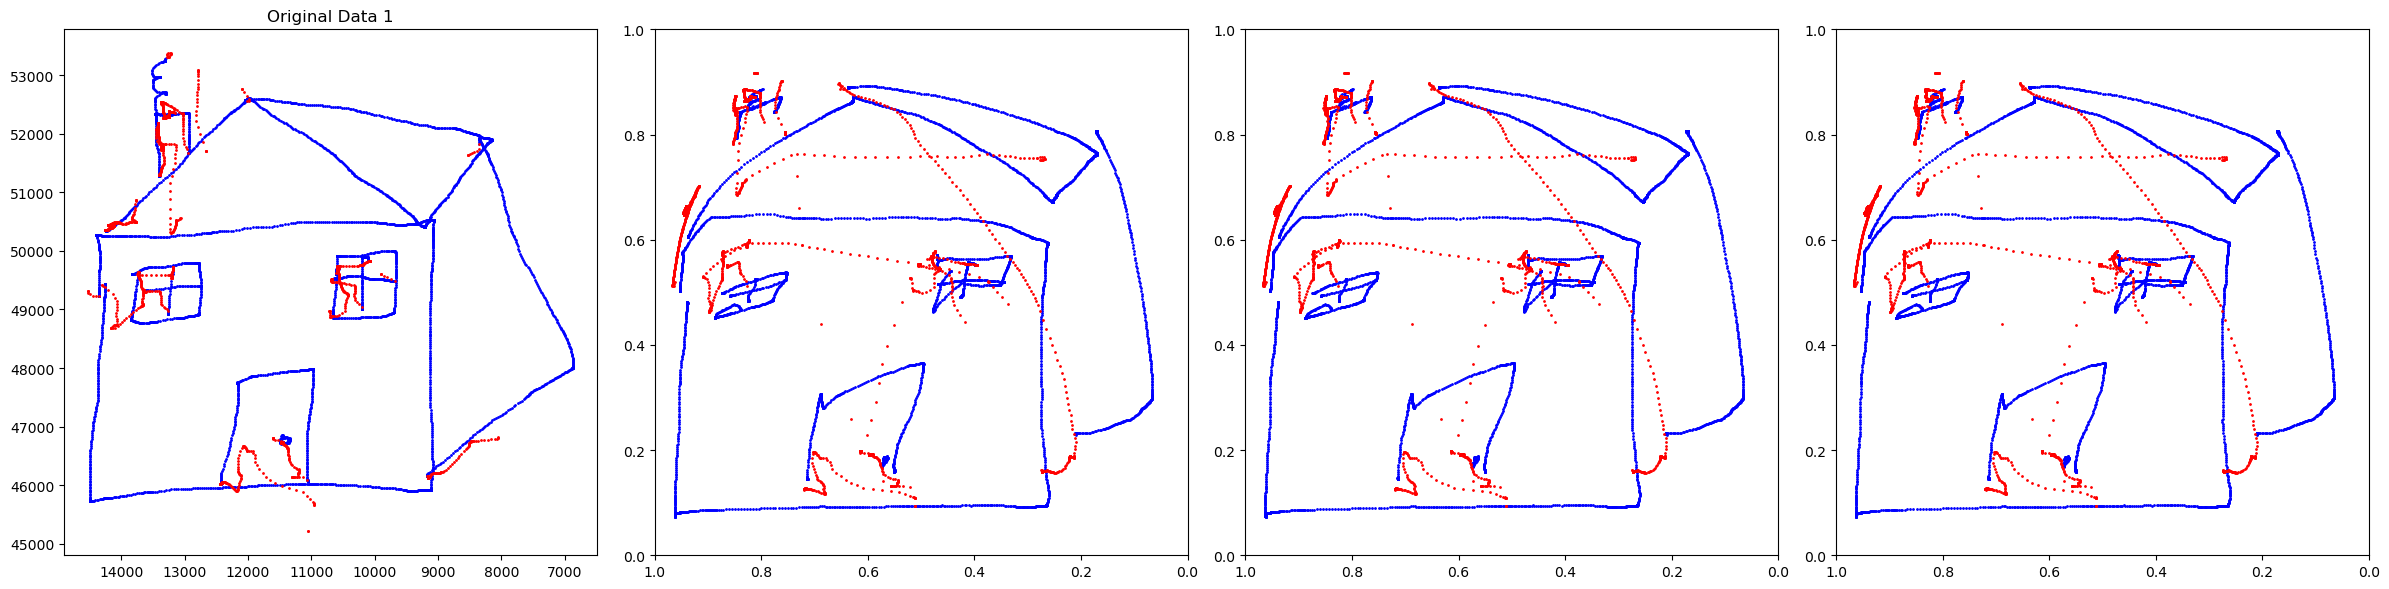

VAE model saved for epoch 60 at vae_models\epoch_60_model.h5.


Epoch 61/100: 100%|██████████| 12/12 [00:01<00:00, 11.23batch/s, Generator Loss=0.000642, Reconstruction Loss=0.000639, KL Loss=3.31]


Epoch 61: Generator Loss = 0.000777, Reconstruction Loss = 0.000774, KL Divergence Loss = 3.408362
NRMSE = 0.328392


Epoch 62/100: 100%|██████████| 12/12 [00:00<00:00, 14.32batch/s, Generator Loss=0.000703, Reconstruction Loss=0.000699, KL Loss=3.37]


Epoch 62: Generator Loss = 0.000662, Reconstruction Loss = 0.000658, KL Divergence Loss = 3.423885
NRMSE = 0.328869


Epoch 63/100: 100%|██████████| 12/12 [00:00<00:00, 12.71batch/s, Generator Loss=0.000601, Reconstruction Loss=0.000598, KL Loss=3.52]


Epoch 63: Generator Loss = 0.000679, Reconstruction Loss = 0.000675, KL Divergence Loss = 3.446143
NRMSE = 0.328855


Epoch 64/100: 100%|██████████| 12/12 [00:00<00:00, 14.90batch/s, Generator Loss=0.000534, Reconstruction Loss=0.00053, KL Loss=3.52] 


Epoch 64: Generator Loss = 0.000631, Reconstruction Loss = 0.000628, KL Divergence Loss = 3.462517
NRMSE = 0.329420


Epoch 65/100: 100%|██████████| 12/12 [00:00<00:00, 19.16batch/s, Generator Loss=0.000646, Reconstruction Loss=0.000642, KL Loss=3.47]


Epoch 65: Generator Loss = 0.000616, Reconstruction Loss = 0.000612, KL Divergence Loss = 3.480762
NRMSE = 0.328991


Epoch 66/100: 100%|██████████| 12/12 [00:00<00:00, 16.22batch/s, Generator Loss=0.000521, Reconstruction Loss=0.000517, KL Loss=3.38]


Epoch 66: Generator Loss = 0.000576, Reconstruction Loss = 0.000573, KL Divergence Loss = 3.499206
NRMSE = 0.328649


Epoch 67/100: 100%|██████████| 12/12 [00:00<00:00, 15.26batch/s, Generator Loss=0.000808, Reconstruction Loss=0.000804, KL Loss=3.53]


Epoch 67: Generator Loss = 0.000661, Reconstruction Loss = 0.000657, KL Divergence Loss = 3.519998
NRMSE = 0.328043


Epoch 68/100: 100%|██████████| 12/12 [00:00<00:00, 13.20batch/s, Generator Loss=0.000646, Reconstruction Loss=0.000642, KL Loss=3.6] 


Epoch 68: Generator Loss = 0.000631, Reconstruction Loss = 0.000627, KL Divergence Loss = 3.537707
NRMSE = 0.329746


Epoch 69/100: 100%|██████████| 12/12 [00:01<00:00,  9.09batch/s, Generator Loss=0.000635, Reconstruction Loss=0.000631, KL Loss=3.56]


Epoch 69: Generator Loss = 0.000584, Reconstruction Loss = 0.000580, KL Divergence Loss = 3.544196
NRMSE = 0.329789


Epoch 70/100: 100%|██████████| 12/12 [00:00<00:00, 15.35batch/s, Generator Loss=0.000563, Reconstruction Loss=0.00056, KL Loss=3.58] 


Epoch 70: Generator Loss = 0.000515, Reconstruction Loss = 0.000511, KL Divergence Loss = 3.563522
NRMSE = 0.328475


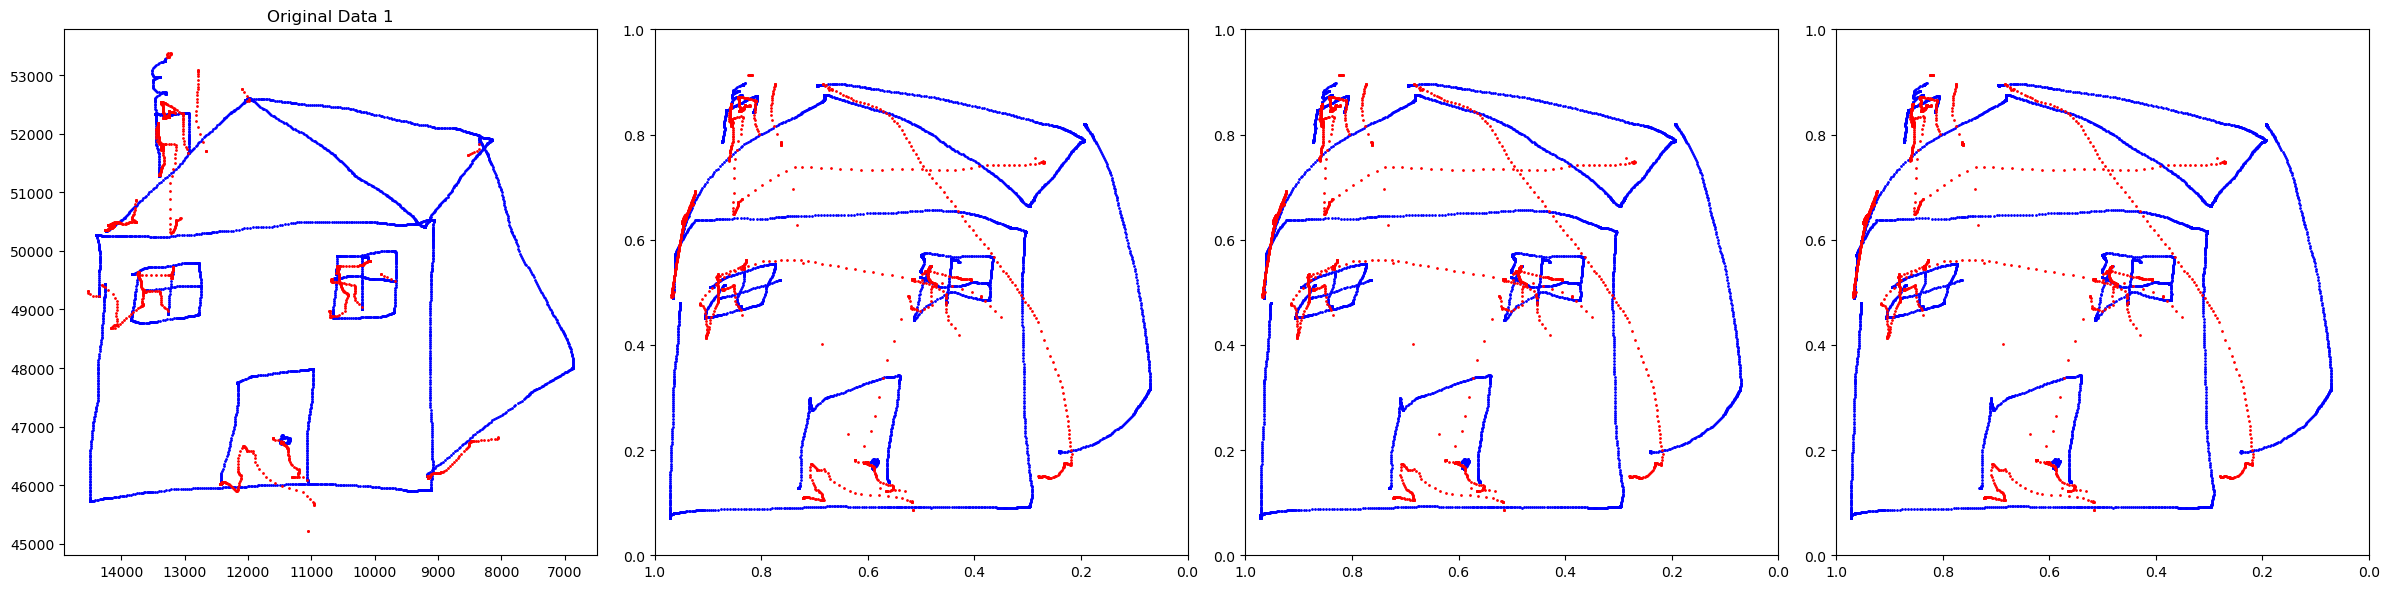

VAE model saved for epoch 70 at vae_models\epoch_70_model.h5.


Epoch 71/100: 100%|██████████| 12/12 [00:01<00:00, 10.94batch/s, Generator Loss=0.000494, Reconstruction Loss=0.000491, KL Loss=3.58]


Epoch 71: Generator Loss = 0.000504, Reconstruction Loss = 0.000500, KL Divergence Loss = 3.584282
NRMSE = 0.329142


Epoch 72/100: 100%|██████████| 12/12 [00:01<00:00,  9.00batch/s, Generator Loss=0.000456, Reconstruction Loss=0.000452, KL Loss=3.73]


Epoch 72: Generator Loss = 0.000514, Reconstruction Loss = 0.000511, KL Divergence Loss = 3.609648
NRMSE = 0.328274


Epoch 73/100: 100%|██████████| 12/12 [00:01<00:00,  7.78batch/s, Generator Loss=0.000756, Reconstruction Loss=0.000752, KL Loss=3.66]


Epoch 73: Generator Loss = 0.000537, Reconstruction Loss = 0.000533, KL Divergence Loss = 3.622237
NRMSE = 0.328838


Epoch 74/100: 100%|██████████| 12/12 [00:01<00:00,  8.78batch/s, Generator Loss=0.000493, Reconstruction Loss=0.000489, KL Loss=3.64]


Epoch 74: Generator Loss = 0.000556, Reconstruction Loss = 0.000552, KL Divergence Loss = 3.636115
NRMSE = 0.329664


Epoch 75/100: 100%|██████████| 12/12 [00:01<00:00,  9.66batch/s, Generator Loss=0.000399, Reconstruction Loss=0.000396, KL Loss=3.63]


Epoch 75: Generator Loss = 0.000442, Reconstruction Loss = 0.000438, KL Divergence Loss = 3.646152
NRMSE = 0.328688


Epoch 76/100: 100%|██████████| 12/12 [00:01<00:00, 10.81batch/s, Generator Loss=0.000392, Reconstruction Loss=0.000388, KL Loss=3.54]


Epoch 76: Generator Loss = 0.000449, Reconstruction Loss = 0.000445, KL Divergence Loss = 3.663789
NRMSE = 0.328296


Epoch 77/100: 100%|██████████| 12/12 [00:00<00:00, 15.01batch/s, Generator Loss=0.000402, Reconstruction Loss=0.000398, KL Loss=3.74]


Epoch 77: Generator Loss = 0.000556, Reconstruction Loss = 0.000552, KL Divergence Loss = 3.688382
NRMSE = 0.328930


Epoch 78/100: 100%|██████████| 12/12 [00:00<00:00, 13.79batch/s, Generator Loss=0.000629, Reconstruction Loss=0.000626, KL Loss=3.59]


Epoch 78: Generator Loss = 0.000546, Reconstruction Loss = 0.000543, KL Divergence Loss = 3.688384
NRMSE = 0.328626


Epoch 79/100: 100%|██████████| 12/12 [00:00<00:00, 14.21batch/s, Generator Loss=0.000562, Reconstruction Loss=0.000559, KL Loss=3.8] 


Epoch 79: Generator Loss = 0.000629, Reconstruction Loss = 0.000626, KL Divergence Loss = 3.704636
NRMSE = 0.329148


Epoch 80/100: 100%|██████████| 12/12 [00:00<00:00, 14.37batch/s, Generator Loss=0.000653, Reconstruction Loss=0.000649, KL Loss=3.59]


Epoch 80: Generator Loss = 0.000695, Reconstruction Loss = 0.000692, KL Divergence Loss = 3.690882
NRMSE = 0.326903


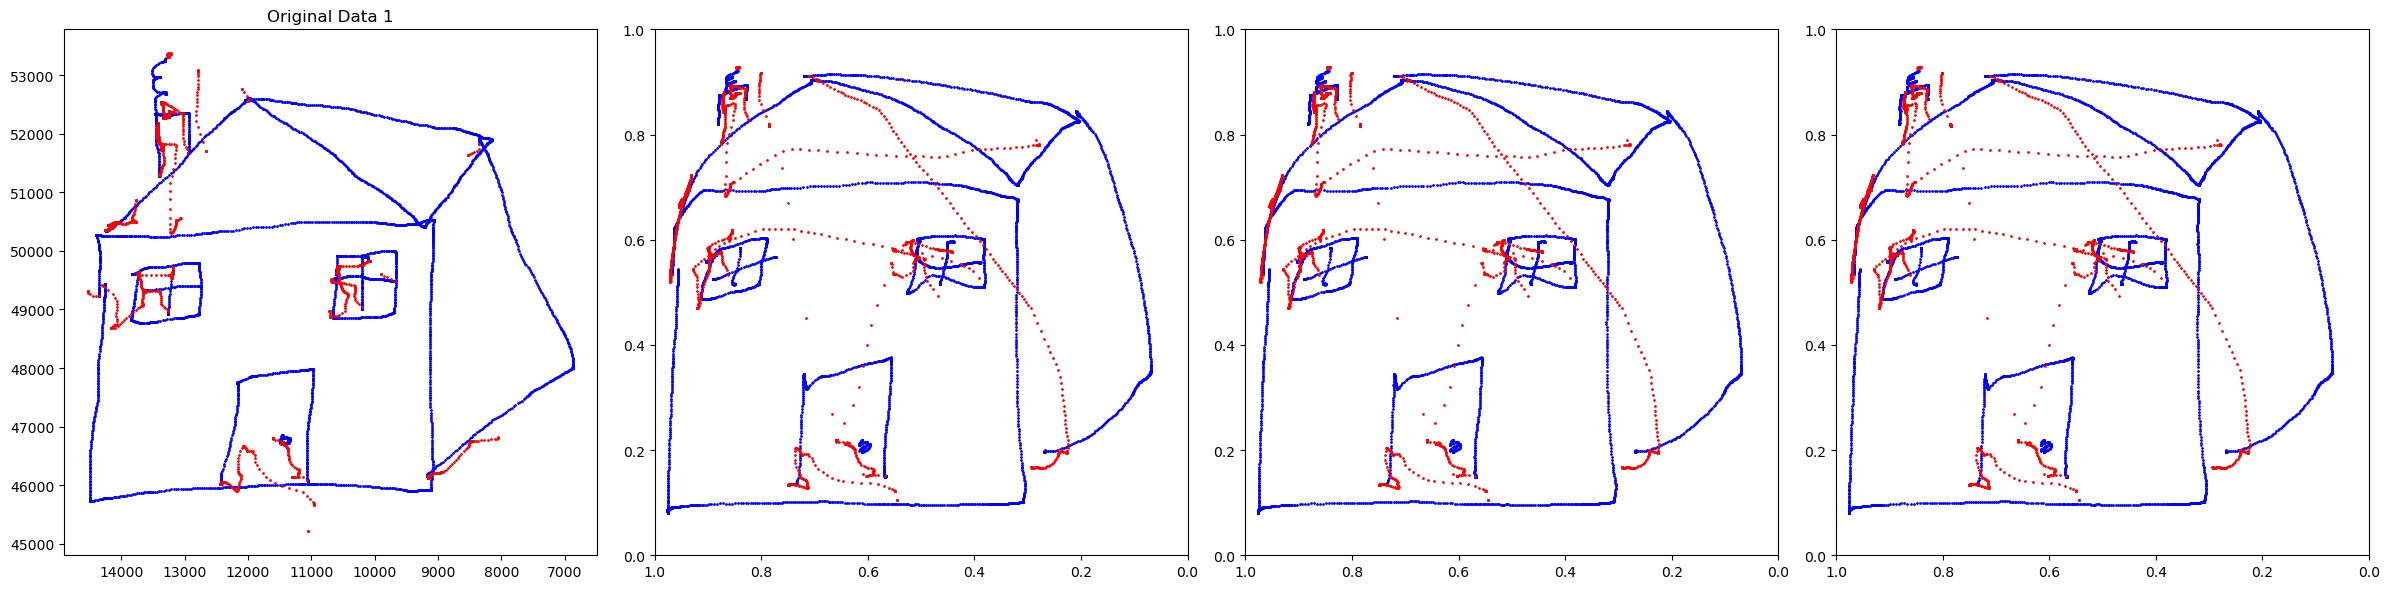

VAE model saved for epoch 80 at vae_models\epoch_80_model.h5.


Epoch 81/100: 100%|██████████| 12/12 [00:01<00:00,  9.57batch/s, Generator Loss=0.00126, Reconstruction Loss=0.00126, KL Loss=3.77]  


Epoch 81: Generator Loss = 0.000947, Reconstruction Loss = 0.000943, KL Divergence Loss = 3.679578
NRMSE = 0.328974


Epoch 82/100: 100%|██████████| 12/12 [00:01<00:00,  6.26batch/s, Generator Loss=0.000608, Reconstruction Loss=0.000605, KL Loss=3.62]


Epoch 82: Generator Loss = 0.001009, Reconstruction Loss = 0.001005, KL Divergence Loss = 3.634491
NRMSE = 0.328260


Epoch 83/100: 100%|██████████| 12/12 [00:01<00:00,  9.18batch/s, Generator Loss=0.000444, Reconstruction Loss=0.00044, KL Loss=3.44] 


Epoch 83: Generator Loss = 0.000725, Reconstruction Loss = 0.000721, KL Divergence Loss = 3.589170
NRMSE = 0.329173


Epoch 84/100: 100%|██████████| 12/12 [00:01<00:00, 10.63batch/s, Generator Loss=0.00065, Reconstruction Loss=0.000646, KL Loss=3.56]


Epoch 84: Generator Loss = 0.000792, Reconstruction Loss = 0.000789, KL Divergence Loss = 3.566623
NRMSE = 0.329679


Epoch 85/100: 100%|██████████| 12/12 [00:00<00:00, 15.70batch/s, Generator Loss=0.000372, Reconstruction Loss=0.000368, KL Loss=3.53]


Epoch 85: Generator Loss = 0.000567, Reconstruction Loss = 0.000563, KL Divergence Loss = 3.564351
NRMSE = 0.329631


Epoch 86/100: 100%|██████████| 12/12 [00:00<00:00, 15.25batch/s, Generator Loss=0.000315, Reconstruction Loss=0.000311, KL Loss=3.53]


Epoch 86: Generator Loss = 0.000412, Reconstruction Loss = 0.000408, KL Divergence Loss = 3.577496
NRMSE = 0.328781


Epoch 87/100: 100%|██████████| 12/12 [00:01<00:00,  9.14batch/s, Generator Loss=0.00036, Reconstruction Loss=0.000356, KL Loss=3.58] 


Epoch 87: Generator Loss = 0.000378, Reconstruction Loss = 0.000374, KL Divergence Loss = 3.601204
NRMSE = 0.328657


Epoch 88/100: 100%|██████████| 12/12 [00:00<00:00, 12.61batch/s, Generator Loss=0.000318, Reconstruction Loss=0.000315, KL Loss=3.51]


Epoch 88: Generator Loss = 0.000356, Reconstruction Loss = 0.000353, KL Divergence Loss = 3.626133
NRMSE = 0.328508


Epoch 89/100: 100%|██████████| 12/12 [00:01<00:00, 10.66batch/s, Generator Loss=0.000385, Reconstruction Loss=0.000381, KL Loss=3.68]


Epoch 89: Generator Loss = 0.000347, Reconstruction Loss = 0.000343, KL Divergence Loss = 3.659917
NRMSE = 0.329218


Epoch 90/100: 100%|██████████| 12/12 [00:00<00:00, 14.97batch/s, Generator Loss=0.000386, Reconstruction Loss=0.000383, KL Loss=3.67]


Epoch 90: Generator Loss = 0.000374, Reconstruction Loss = 0.000370, KL Divergence Loss = 3.686639
NRMSE = 0.329934


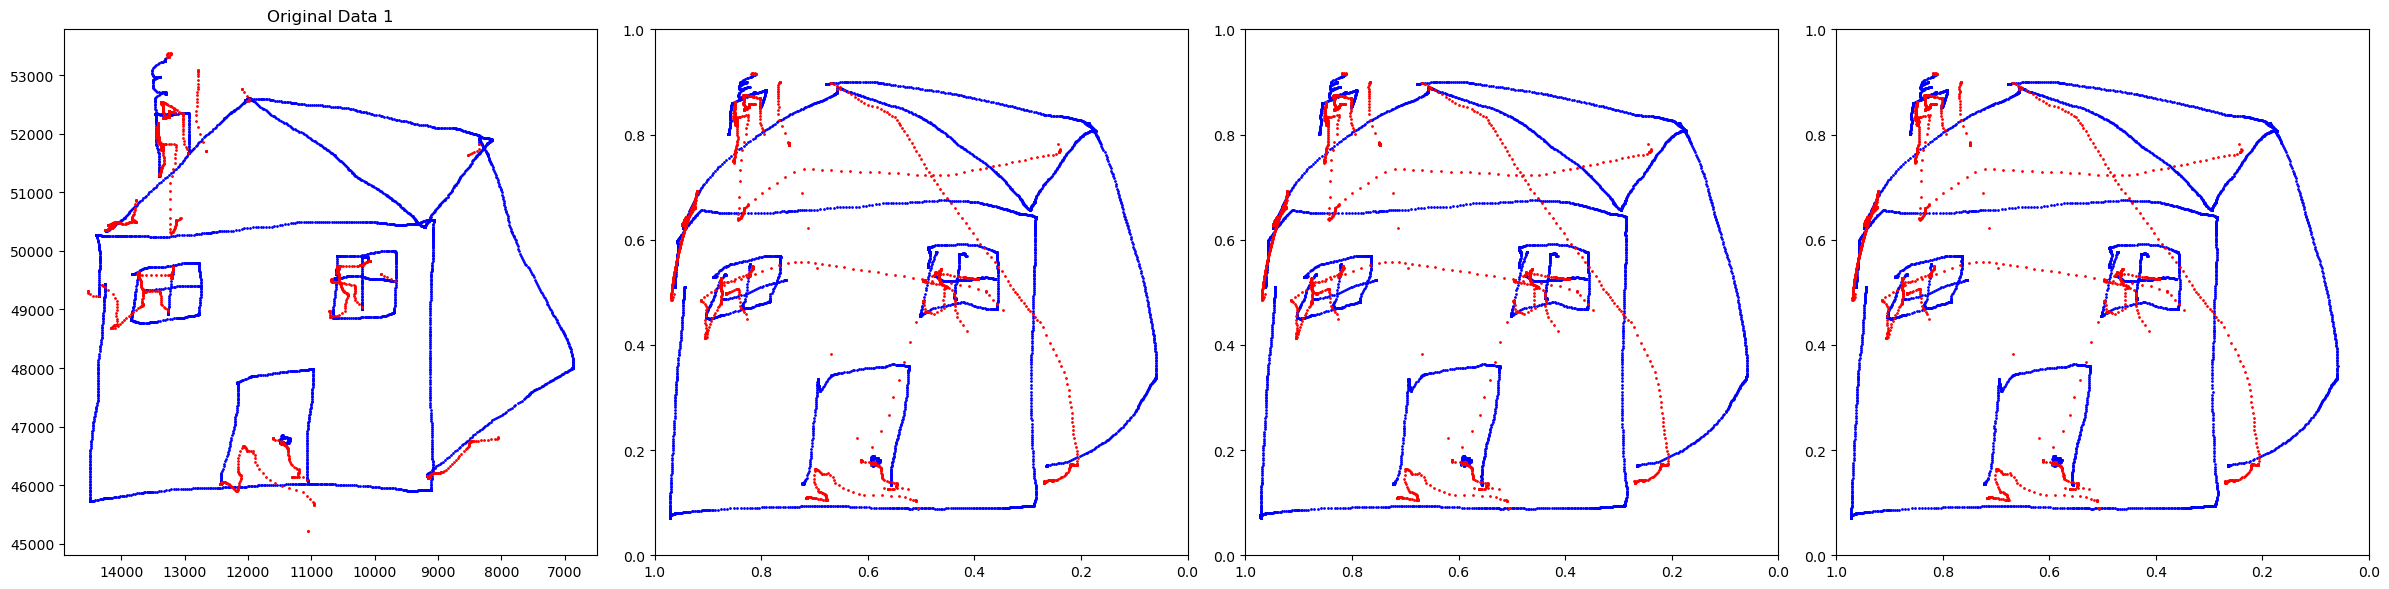

VAE model saved for epoch 90 at vae_models\epoch_90_model.h5.


Epoch 91/100: 100%|██████████| 12/12 [00:00<00:00, 13.95batch/s, Generator Loss=0.000325, Reconstruction Loss=0.000321, KL Loss=3.76]


Epoch 91: Generator Loss = 0.000369, Reconstruction Loss = 0.000365, KL Divergence Loss = 3.711725
NRMSE = 0.328852


Epoch 92/100: 100%|██████████| 12/12 [00:00<00:00, 16.25batch/s, Generator Loss=0.000373, Reconstruction Loss=0.00037, KL Loss=3.71] 


Epoch 92: Generator Loss = 0.000335, Reconstruction Loss = 0.000331, KL Divergence Loss = 3.730686
NRMSE = 0.328851


Epoch 93/100: 100%|██████████| 12/12 [00:00<00:00, 15.61batch/s, Generator Loss=0.000288, Reconstruction Loss=0.000284, KL Loss=3.81]


Epoch 93: Generator Loss = 0.000340, Reconstruction Loss = 0.000336, KL Divergence Loss = 3.755134
NRMSE = 0.328951


Epoch 94/100: 100%|██████████| 12/12 [00:00<00:00, 14.75batch/s, Generator Loss=0.000328, Reconstruction Loss=0.000324, KL Loss=3.74]


Epoch 94: Generator Loss = 0.000336, Reconstruction Loss = 0.000332, KL Divergence Loss = 3.775937
NRMSE = 0.329492


Epoch 95/100: 100%|██████████| 12/12 [00:00<00:00, 15.12batch/s, Generator Loss=0.000312, Reconstruction Loss=0.000309, KL Loss=3.83]


Epoch 95: Generator Loss = 0.000320, Reconstruction Loss = 0.000316, KL Divergence Loss = 3.798239
NRMSE = 0.327598


Epoch 96/100: 100%|██████████| 12/12 [00:00<00:00, 17.80batch/s, Generator Loss=0.000343, Reconstruction Loss=0.000339, KL Loss=3.9]


Epoch 96: Generator Loss = 0.000326, Reconstruction Loss = 0.000322, KL Divergence Loss = 3.820391
NRMSE = 0.328486


Epoch 97/100: 100%|██████████| 12/12 [00:01<00:00, 11.58batch/s, Generator Loss=0.00033, Reconstruction Loss=0.000326, KL Loss=3.89] 


Epoch 97: Generator Loss = 0.000343, Reconstruction Loss = 0.000339, KL Divergence Loss = 3.838373
NRMSE = 0.327556


Epoch 98/100: 100%|██████████| 12/12 [00:00<00:00, 12.47batch/s, Generator Loss=0.000291, Reconstruction Loss=0.000287, KL Loss=3.77]


Epoch 98: Generator Loss = 0.000305, Reconstruction Loss = 0.000301, KL Divergence Loss = 3.851623
NRMSE = 0.329508


Epoch 99/100: 100%|██████████| 12/12 [00:01<00:00, 11.19batch/s, Generator Loss=0.000347, Reconstruction Loss=0.000344, KL Loss=3.88]


Epoch 99: Generator Loss = 0.000356, Reconstruction Loss = 0.000352, KL Divergence Loss = 3.873234
NRMSE = 0.328030


Epoch 100/100: 100%|██████████| 12/12 [00:00<00:00, 17.84batch/s, Generator Loss=0.000444, Reconstruction Loss=0.000441, KL Loss=3.96]


Epoch 100: Generator Loss = 0.000354, Reconstruction Loss = 0.000350, KL Divergence Loss = 3.889922
NRMSE = 0.328897


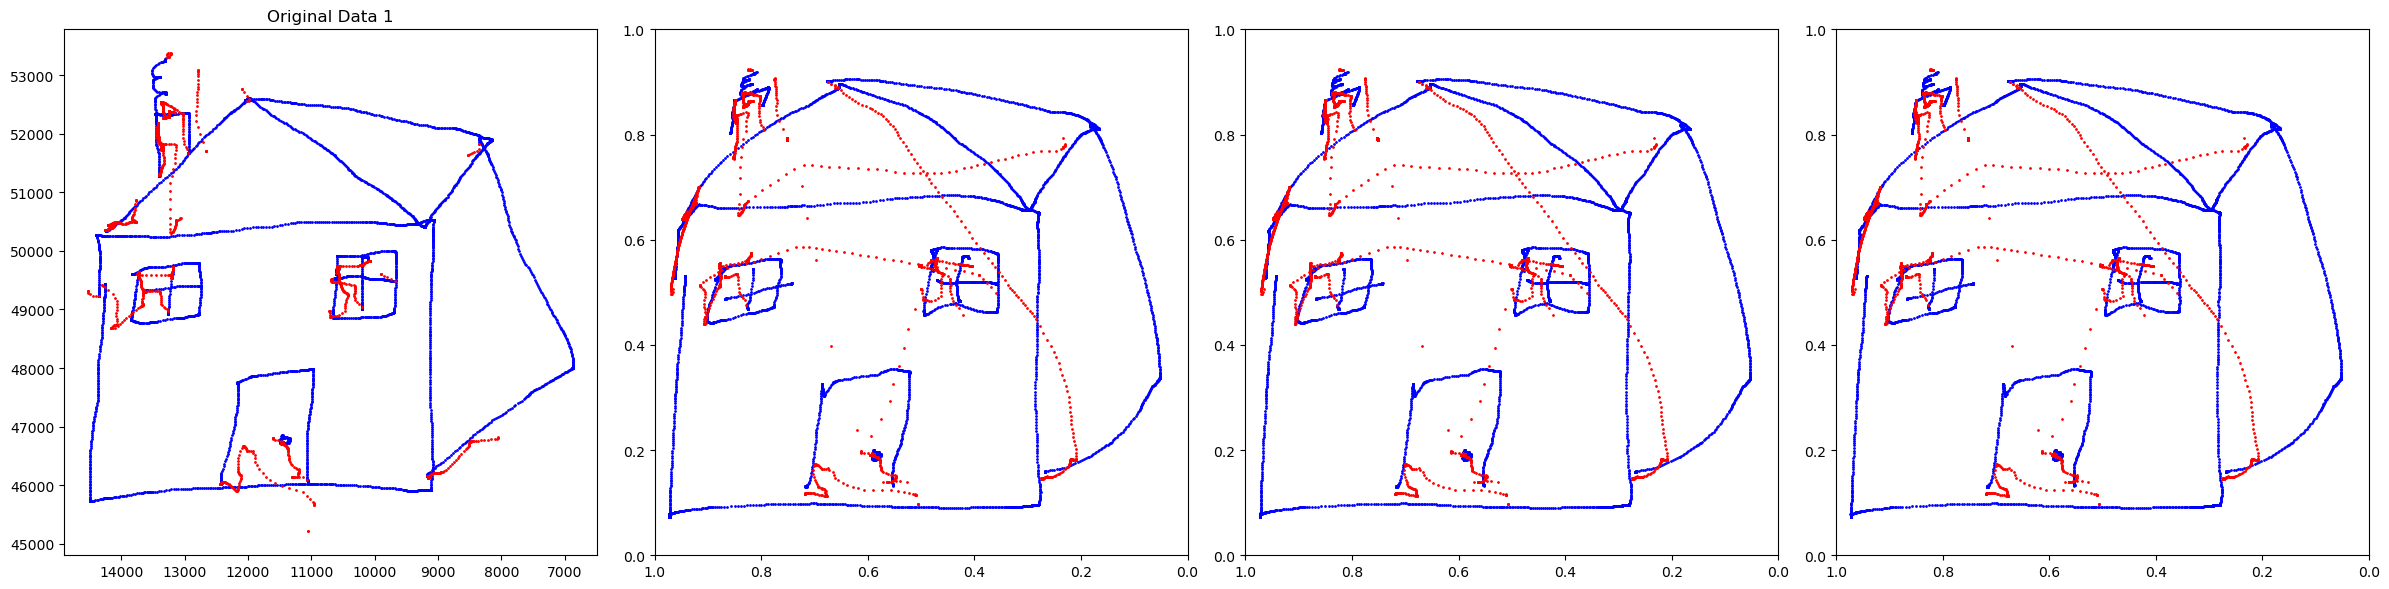

VAE model saved for epoch 100 at vae_models\epoch_100_model.h5.
Final VAE model saved.


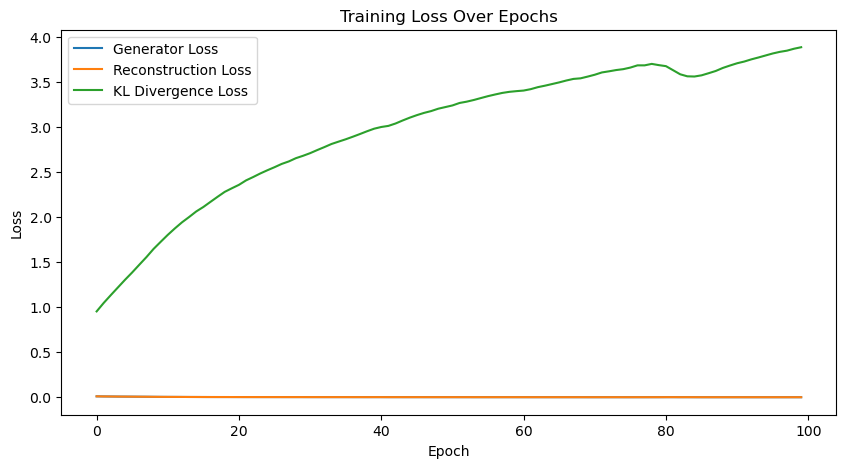

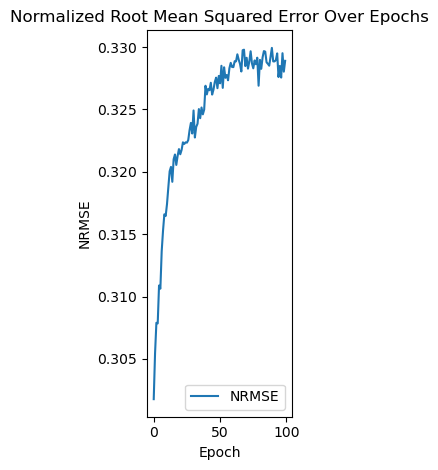

In [9]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss + 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 100
visual_per_num_epoch = 10
num_augmented_files = 1

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)
        num_augmented_files = 3

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
        # Save VAE model after each epoch, directly into the `vae_models` folder
        model_save_path = os.path.join(save_dir, f"epoch_{epoch+1}_model.h5")
        vae.save(model_save_path)
        print(f"VAE model saved for epoch {epoch+1} at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.


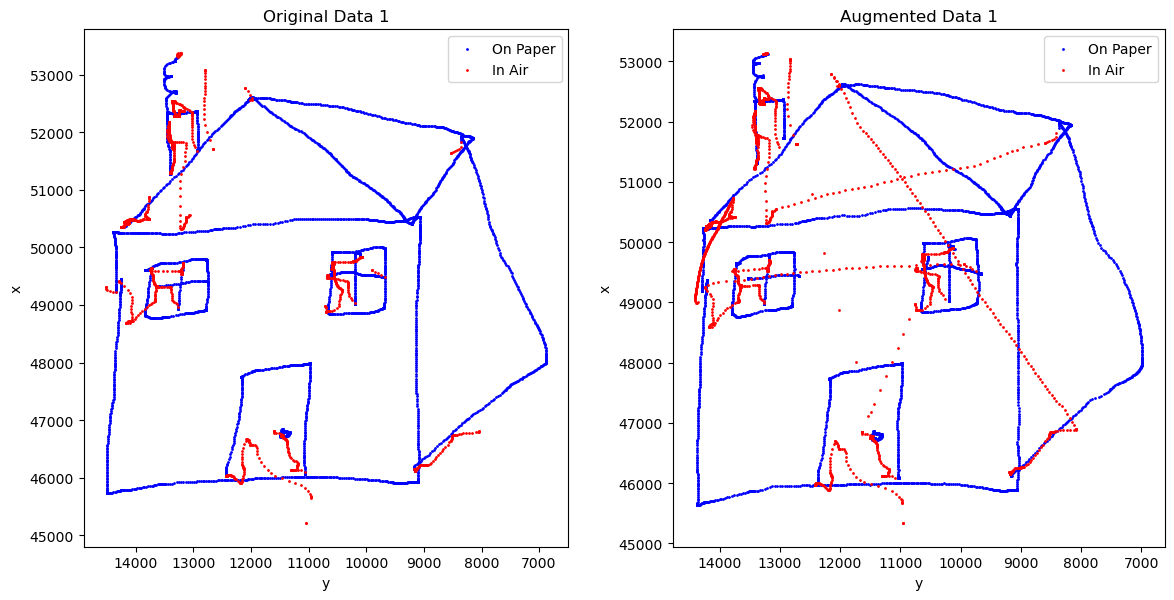

In [17]:
# Cell 8: Plot the original data before imputation using original_data_frames from Cell 2, rotated 90 degrees to the left

# Load the pretrained VAE model
with custom_object_scope({'VAE': VAE}):
    vae_pretrained = load_model('vae_models/epoch_200_model.h5')
print("Pretrained VAE model loaded.")

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
num_augmented_files = 1

# Generate augmented data using the pretrained model
augmented_datasets = generate_augmented_data(vae_pretrained, num_augmented_files, avg_data_points, processed_data, 
                                             base_latent_variability, latent_variability_range)

# Calculate actual latent variabilities and lengths used
latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
augmented_lengths = [len(data) for data in augmented_datasets]

# Function to visualize augmented data after inverse scaling
def visualize_augmented_data(augmented_datasets, scalers, original_data_frames, axs):
    all_augmented_data = []  # List to store augmented datasets after scaling back

    for i, (augmented_data, scaler, original_df) in enumerate(zip(augmented_datasets, scalers, original_data_frames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data from original data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, extend original_paa by repeating the last row
        if len(augmented_data) > len(original_paa):
            last_row = original_paa[-1:]
            repeat_count = len(augmented_data) - len(original_paa)
            extended_rows = np.tile(last_row, (repeat_count, 1))
            original_paa = np.vstack((original_paa, extended_rows))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))
        
        # Store the augmented data for later use
        all_augmented_data.append(augmented_data_original_scale)
        
        # Visualization of the augmented data (after inverse scaling)
        augmented_on_paper = augmented_data_original_scale[augmented_data_original_scale[:, 3] == 1]
        augmented_in_air = augmented_data_original_scale[augmented_data_original_scale[:, 3] == 0]

        # Scatter plot for the augmented data, with rotated axes
        axs[i + len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')  # y -> x, x -> y
        axs[i + len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')  # y -> x, x -> y
        axs[i + len(original_data_frames)].set_title(f'Augmented Data {i + 1}')
        axs[i + len(original_data_frames)].set_xlabel('y')  # Previously 'x'
        axs[i + len(original_data_frames)].set_ylabel('x')  # Previously 'y'
        axs[i + len(original_data_frames)].set_aspect('equal')
        axs[i + len(original_data_frames)].invert_xaxis()  # Flip the horizontal axis (y-axis)
        axs[i + len(original_data_frames)].legend()

    return all_augmented_data  # Return the list of augmented datasets after scaling back

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6 * (num_augmented_files + len(original_data_frames)), 6))

# Plot the original data before imputation, with a 90-degree left rotation and horizontal flip
for i, original_data in enumerate(original_data_frames):  # Use original_data_frames for raw data visualization
    original_on_paper = original_data[original_data['pen_status'] == 1]
    original_in_air = original_data[original_data['pen_status'] == 0]
    
    # Scatter plot for the original data (before imputation), with rotated axes
    axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')  # y -> x, x -> y
    axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')  # y -> x, x -> y
    axs[i].set_title(f'Original Data {i + 1}')
    axs[i].set_xlabel('y')  # Previously 'x'
    axs[i].set_ylabel('x')  # Previously 'y'
    axs[i].set_aspect('equal')
    axs[i].legend()
    
    # Flip the horizontal axis (y-axis)
    axs[i].invert_xaxis()  # This reverses the 'y' axis to flip the plot horizontally

# Set consistent axis limits for square aspect ratio for both original and augmented data
x_min = min(data['x'].min() for data in original_data_frames)
x_max = max(data['x'].max() for data in original_data_frames)
y_min = min(data['y'].min() for data in original_data_frames)
y_max = max(data['y'].max() for data in original_data_frames)

# Plot the augmented data with the same 90-degree left rotation and horizontal flip
all_augmented_data = visualize_augmented_data(augmented_datasets, scalers, original_data_frames, axs)


plt.tight_layout()
plt.show()

In [23]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, extend original_paa by repeating the last row
        if len(augmented_data) > len(original_paa):
            last_row = original_paa[-1:]
            repeat_count = len(augmented_data) - len(original_paa)
            extended_rows = np.tile(last_row, (repeat_count, 1))
            original_paa = np.vstack((original_paa, extended_rows))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")

Augmented data saved to augmented_data\augmented_u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5971, 7)
Shapes of augmented datasets:
Shape of augmented dataset 1: (5971, 7)


In [19]:
# Cell 10 NRMSE
def calculate_nrmse(original, predicted):

    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    
    return nrmse

# Example usage:
nrmse_values = []

# Using all_augmented_data from Cell 9
for i, (original, augmented) in enumerate(zip(data_frames, all_augmented_data)):
    original_array = original[['x', 'y', 'timestamp', 'pen_status']].values
    augmented_array = augmented[:, :4]  # Assuming first 4 columns match original data structure

    nrmse = calculate_nrmse(original_array, augmented_array)
    nrmse_values.append(nrmse)

# Print results
for i, nrmse in enumerate(nrmse_values):
    print(f"NRMSE for dataset {i+1}: {nrmse:.4f}")

# Calculate average NRMSE
average_nrmse = np.mean(nrmse_values)
print(f"Average NRMSE: {average_nrmse:.4f}")

NRMSE for dataset 1: 0.0033
Average NRMSE: 0.0033


In [ ]:
# Cell 11 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    # Determine the number of features to use (minimum of real and synthetic data)
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    
    # Trim the features to match
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape the data for LSTM input (samples, timesteps, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        model.fit(X_train, y_train, epochs=3, batch_size=256, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return mean_accuracy, std_accuracy

# Assuming 'processed_data' contains the real data and 'augmented_datasets' contains the synthetic data
real_data = np.concatenate(processed_data, axis=0)
synthetic_data = np.concatenate(augmented_datasets, axis=0)

mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"\nPost-Hoc Discriminative Score Results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Interpret the results
if abs(mean_accuracy - 0.5) < 0.05:
    print("\nThe synthetic data is effectively indistinguishable from real data.")
elif mean_accuracy > 0.55:
    print("\nThe classifier can distinguish between real and synthetic data with some accuracy.")
    print("This suggests that the synthetic data may not fully capture all characteristics of the real data.")
else:
    print("\nThe classifier performs worse than random guessing.")
    print("This might indicate issues with the classification process or highly varied data.")

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.4907 - loss: 0.6932
Epoch 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4992 - loss: 0.6932
Epoch 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5014 - loss: 0.6931
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4933 - loss: 0.6932
Epoch 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5030 - loss: 0.6931
Epoch 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4963 - loss: 0.6932
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3


In [30]:
# Cell 12 Post Hoc Predictive Score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from tqdm import tqdm

# Step 1: Prepare Data
def prepare_data(df, time_steps=5):
    data = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences of length `time_steps`
    X, y = [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps])
    
    return np.array(X), np.array(y), scaler

# Example usage
X, y, scaler = prepare_data(data_frames[0])

# Custom callback for progress bar
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training Progress")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Adding dropout to introduce randomness
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2))  # Predict x and y
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 3: Evaluate Model Function
def evaluate_model(model, X_test, y_test, scaler):
    # Predict and inverse transform
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Compute MAPE for each test sample
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
    print(f"\nMAPE: {mape * 100:.2f}%")
    
    # Interpretation of MAPE
    if mape < 0.1:
        interpretation = "Excellent prediction"
    elif mape < 0.2:
        interpretation = "Good prediction"
    elif mape < 0.5:
        interpretation = "Fair prediction"
    else:
        interpretation = "Poor prediction"
    
    print(f"Interpretation: {interpretation}")
    
    return mape

# Step 4: K-Fold Cross-Validation Implementation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.randint(1000))  # 10-fold cross-validation

mape_values = []
for train_index, test_index in kf.split(X):
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train the model for each fold
    model = create_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=0, callbacks=[CustomCallback()])
    
    # Evaluate the model and store MAPE
    mape = evaluate_model(model, X_test, y_test, scaler)
    mape_values.append(mape)

# Step 5: Calculate Mean and Standard Deviation of MAPE
mean_mape = np.mean(mape_values)
std_mape = np.std(mape_values)

print(f"\nMean MAPE: {mean_mape * 100:.2f}%")
print(f"Standard Deviation of MAPE: {std_mape * 100:.2f}%")


Post-Hoc Predictive Score Results:
Mean MAPE: 25.4194
Standard Deviation of MAPE: 0.0000
Synthetic Data NaNs: False
Real Data NaNs: False
Synthetic Data Infs: False
Real Data Infs: False
Synthetic Data Shape: (5971, 4)
Real Data Shape: (5971, 4)

The synthetic data may not fully capture the patterns of the original data.
Consider refining the data generation process.


In [12]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, extend original_paa by repeating the last row
        if len(augmented_data) > len(original_paa):
            last_row = original_paa[-1:]
            repeat_count = len(augmented_data) - len(original_paa)
            extended_rows = np.tile(last_row, (repeat_count, 1))
            original_paa = np.vstack((original_paa, extended_rows))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")

Augmented data saved to augmented_data\augmented_u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5971, 7)
Shapes of augmented datasets:
Shape of augmented dataset 1: (5971, 7)


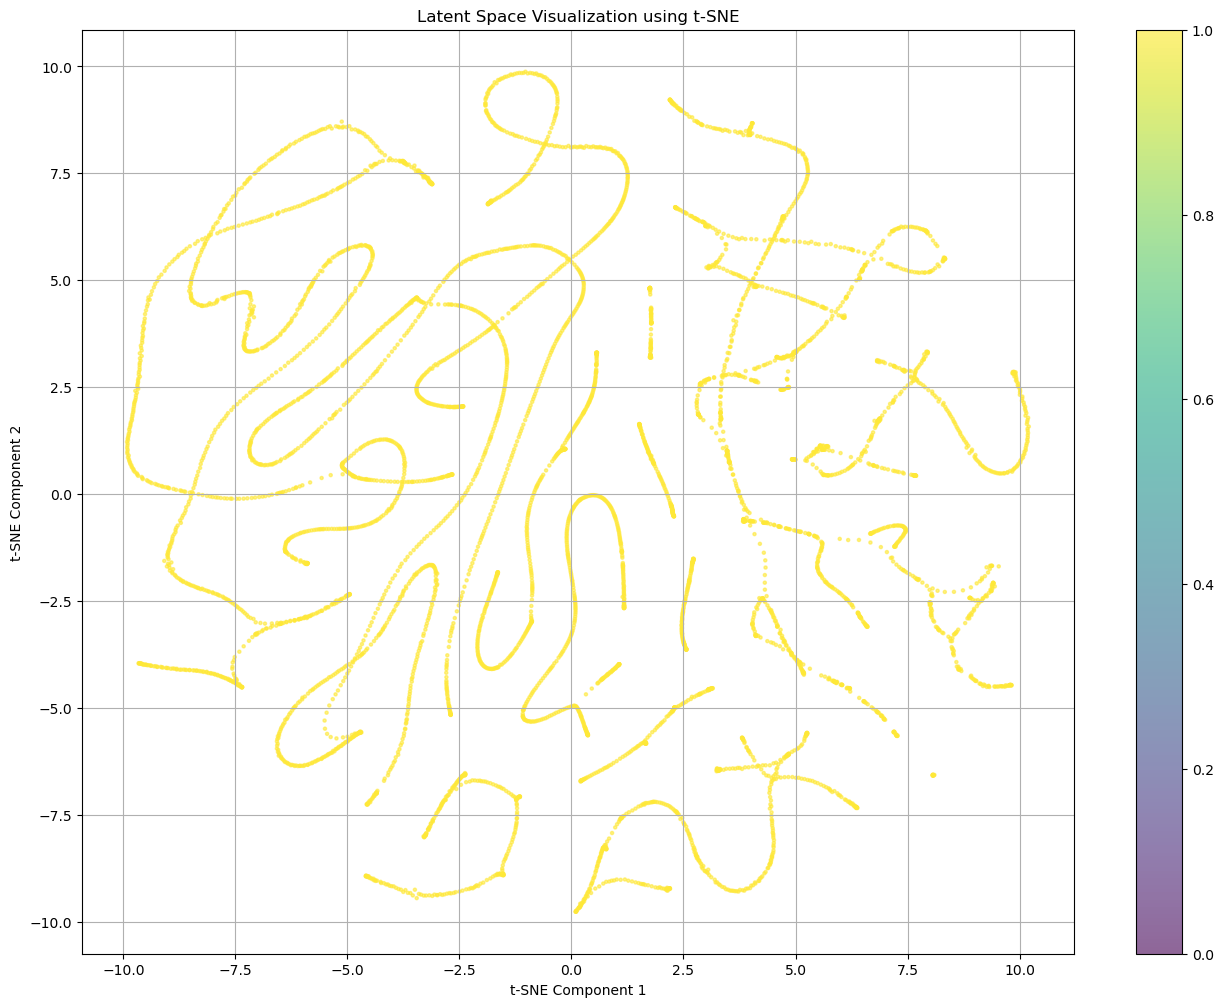

In [22]:
#Cell 11 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])